## Modelo SIR en parareal (Julia)

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R_{t} & = \nu I 
\end{align}

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R(t) & = N - S(t)-I(t)
\end{align}


In [2]:
# Parámetros globales

const global N_ind = 103 # Número de individuos  
const global beta = 0.1
const global nu = 0.9

const global S0 = 100.
const global I0 = 3.
const global R0 = N_ind-S0-I0
const global U0 = [S0, I0, R0]

const global t_init = 0.
const global t_end  = 5. 
const global t_n_f = 100000
const global t_n_c = 100

const global N_intervalos = 500;
const global T = LinRange(t_init, t_end, N_intervalos+1)

const global n_iter = 4 # Número de iteraciones de Parareal

SIR_1(S,I) = -beta*S*I
SIR_2(S,I) =  beta*S*I-nu*I
SIR_3(S,I) =  nu*I

SIR_3 (generic function with 1 method)

## Array de incógintas, $U[i,j,k]$

- Primer índice $i$: subintervalo
- Segundo índice $j$: iteración parareal
- Terecer ínidice $k$: incógnita
    * 1 -> S
    * 2 -> I
    * 3 -> R

## Método de Euler

In [3]:
# Resuelve el sistema de EDO U' = F(U,t), U(0)=U0 en el rango 
# de tiempo T = [t_0, ..., t_n] mediante el método de Euler
# Almacena la solución en U_sol
function Euler_SIR(U0, t_init, t_end, n_t)
    dt = (t_end-t_init)/n_t
    t = t_init
    
    #println("n_t=$n_t, t_init=$t_init, t_end=$t_end, dt=$dt")
    # U_sol = zeros(size(U0))
    S0, I0, R0 = U0
    S1, I1, R1 = U0
    for i=1:n_t
        # Denotamos: U=solución en la etapa actual, U0=sol. etapa anterior
        S1 = S0 + dt*SIR_1(S0, I0)
        I1 = I0 + dt*SIR_2(S0, I0)
        R1 = R0 + dt*SIR_3(S0, I0)

        # Preparamos siguiente iteración
        t += dt
        S0, I0, R0 = S1, I1, R1
        
        #println("Iter $i, t=$t, u=$U_sol, ex_sol=$(exp(t))")
    end
    return [S1, I1, R1]
end

Euler_SIR (generic function with 1 method)

 ## Método Parareal

In [4]:
@inline F(t1, t0, u0) =  Euler_SIR(u0, t0, t1, t_n_f)
@inline G(t1, t0, u0) =  Euler_SIR(u0, t0, t1, t_n_c)
#F!(t1, t0, u0, U_sol) =  Euler_SIR!(u0, t0, t1, t_n_f, U_sol)
#G!(t1, t0, u0, U_sol) =  Euler_SIR!(u0, t0, t1, t_n_c, U_sol)

G (generic function with 1 method)

In [5]:
function SIR_secuencial()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @time @inbounds begin
        for n = 1:N_intervalos
            #F_sol[n,:] = F( T[n+1], T[n], U[n,k,:] )
            t0 = T[n]
            t1 = T[n+1]
            Unk = U[n,k,:]
            Fn[n,:] = F( t1, t0, Unk )
        end
        end
        
        # 2.b) Corrección secuencial
        for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end
    end
    
    return U
    
end

SIR_secuencial (generic function with 1 method)

In [6]:
function SIR_parareal()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);
    Un = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @time begin
        @inbounds Threads.@threads for n = 1:N_intervalos
            t0 = T[n]
            t1 = T[n+1]
            #Unk = U[n,k,:]
            Fn[n,:] = F( t1, t0, U[n,k,:])
        end
        end
        
        # 2.b) Corrección secuencial
        for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end

    end
    
    return U
    
end

SIR_parareal (generic function with 1 method)

In [8]:
@time U = SIR_secuencial();

  0.495848 seconds (1000 allocations: 109.375 KiB)
  0.497661 seconds (1000 allocations: 109.375 KiB)
  0.495317 seconds (1000 allocations: 109.375 KiB)
  0.494979 seconds (1000 allocations: 109.375 KiB)
  1.993394 seconds (20.05 k allocations: 2.141 MiB)


In [13]:
@time U = SIR_parareal(); 

  0.037604 seconds (1.12 k allocations: 121.375 KiB)
  0.034175 seconds (1.12 k allocations: 121.344 KiB)
  0.032716 seconds (1.12 k allocations: 121.344 KiB)
  0.032675 seconds (1.26 k allocations: 131.078 KiB)
  0.147275 seconds (20.41 k allocations: 2.195 MiB)


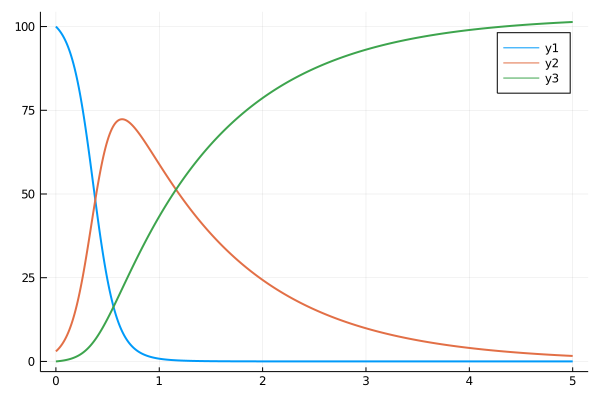

In [15]:
#import Pkg; Pkg.add("Plots")

using Plots

y = U[:,end,:]; # Susceptibles
x = T
plot(x, y, linewidth = 2)

## Comparación con Euler


In [18]:
N_total = N_intervalos*t_n_f
@time resultado = Euler_SIR(U0, t_init, t_end, N_total)

  0.500883 seconds (5 allocations: 272 bytes)


3-element Array{Float64,1}:
   0.0012846402101443649
   1.6367163742493127   
 101.3619989855094      

In [21]:
dif = resultado - U[end,end,:]
error_absoluto = sqrt( sum(dif.^2) ) 
error_relativo = error_absoluto / sqrt(sum(resultado.^2))
println("Diferencia entre el método de Euler y Parareal/Euler en la última iteración:")
println("Error absoluto: $error_absoluto.\nError relativo: $error_relativo")

Diferencia entre el método de Euler y Parareal/Euler en la última iteración:
Error absoluto: 3.411490459114631e-13.
Error relativo: 3.365211652620032e-15
